# GJ436

In [1]:
from glob import glob
import ombre as om
import numpy as np
import matplotlib.pyplot as plt

In [2]:
name = 'GJ436'

In [3]:
fnames = np.asarray(glob(f'/Volumes/Nibelheim/hst/data/{name}/*.fits'))
obs = om.Observation.from_files(fnames)

/Users/ch/HST/projects/ombre/src/ombre/visit.py:208: RuntimeWarning: divide by zero encountered in true_divide
  w[self.err / self.sci > 0.1] = 1e10


In [5]:
import lightkurve as lk
import astropy.units as u
clc = lk.search_lightcurve(name, mission='TESS', author='SPOC', exptime=120).download_all().stitch().remove_nans()
clc.flux = clc.flux.value * u.electron/u.s
clc.flux_err = clc.flux_err.value * u.electron/u.s

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

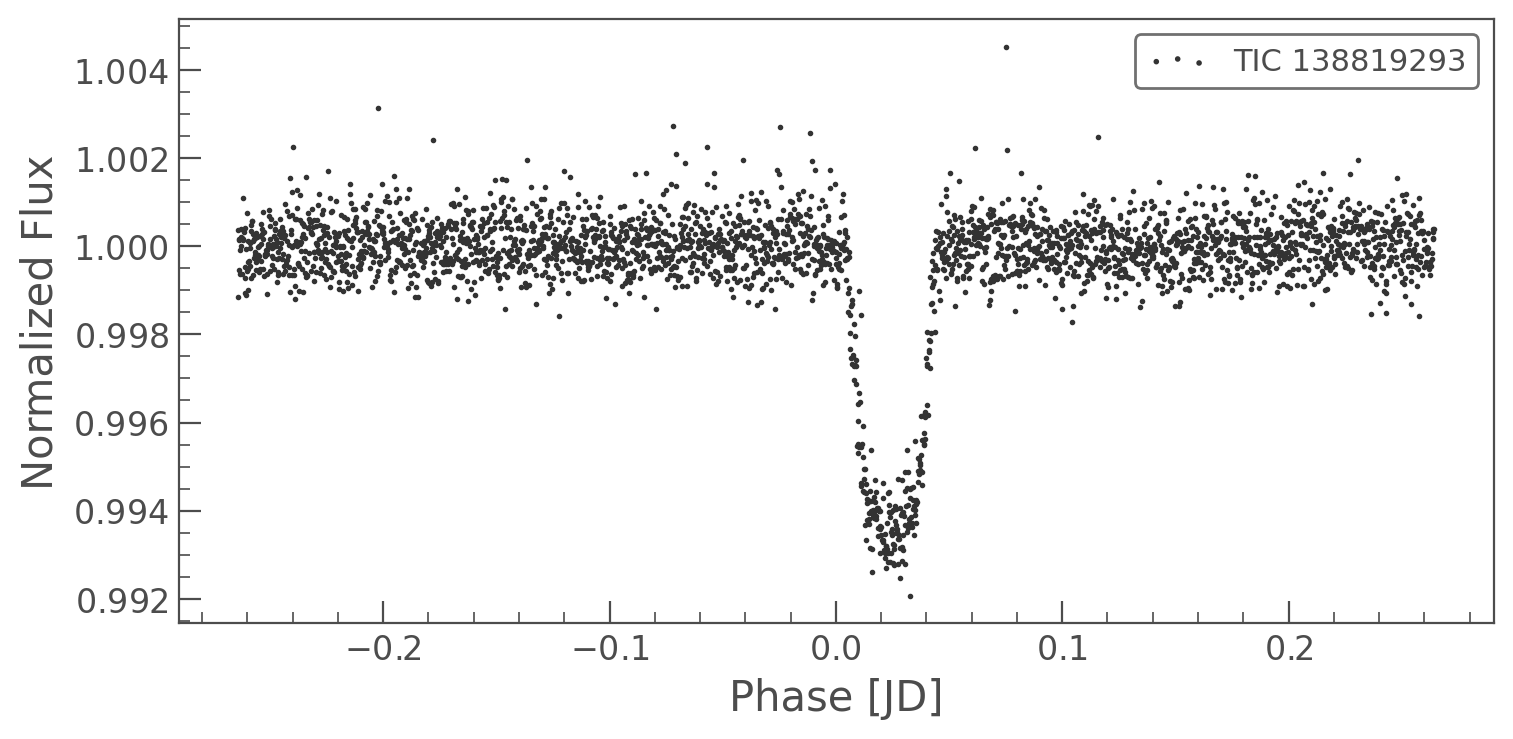

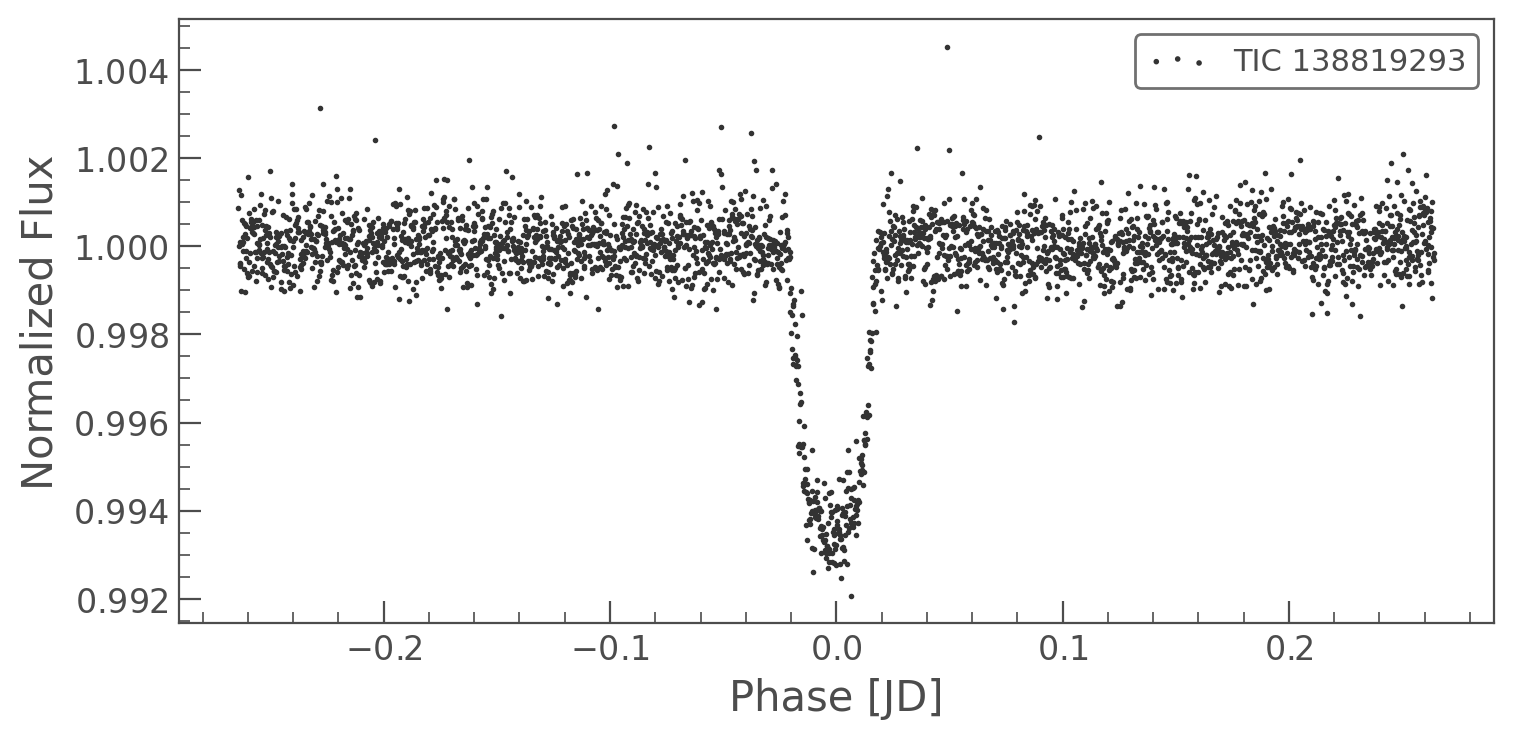

In [6]:
k = np.abs(((clc.time.value - (obs.t0 - 2457000 + obs.period/2))/obs.period) % 1 - 0.5) < 0.1
clc[k].fold(obs.period, obs.t0 - 2457000).scatter()

bls = clc.to_periodogram('bls', minimum_period=obs.period * 0.99, maximum_period=obs.period * 1.01, duration=obs.duration/24, frequency_factor=0.1)
obs.period, obs.t0 = bls.period_at_max_power.value, bls.transit_time_at_max_power.value + 2457000

k = np.abs(((clc.time.value - (obs.t0 - 2457000 + obs.period/2))/obs.period) % 1 - 0.5) < 0.1
clc[k].fold(obs.period, obs.t0 - 2457000).scatter()


In [7]:
obs

GJ-436 [8 Visits]

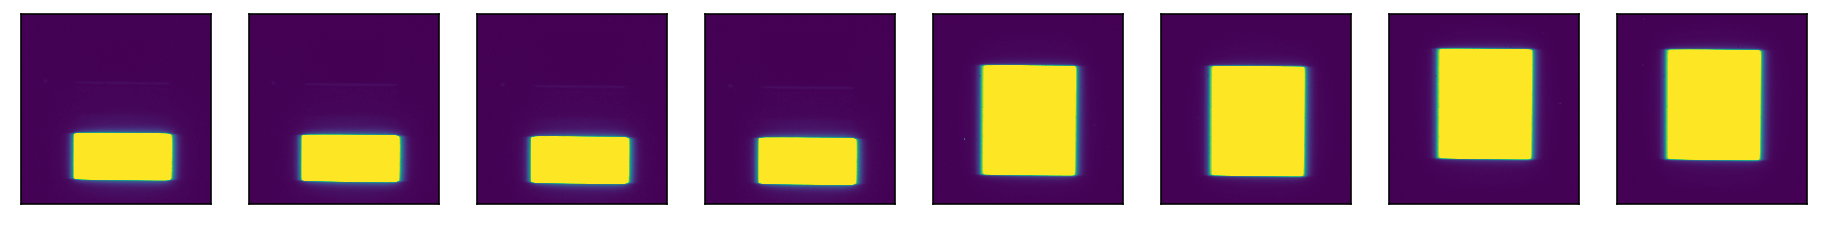

In [8]:
fig, ax = plt.subplots(1, len(obs), figsize=(len(obs) * 2, 2))
for idx, visit in enumerate(obs):
    ax[idx].imshow(visit.sci[0], vmin=0, vmax=1000)
    ax[idx].set(xticks=[], yticks=[])

In [9]:
obs.fit_transit(x_suppl=clc.time.value[k] + 2457000,
                y_suppl=clc.flux.value[k],
                yerr_suppl=clc.flux_err.value[k],
                exptime_suppl=np.median(np.diff(clc.time.value)), fit_t0=True, fit_period=False, fit_inc=False)

In [25]:
obs.period = 2.64388312
obs.t0 = 2454865.084034

In [27]:
obs[-1]

GJ436 Visit 6, Forward False [Proposal ID: 13338]

<AxesSubplot:xlabel='Phase', ylabel='$e^-s^{-1}$'>

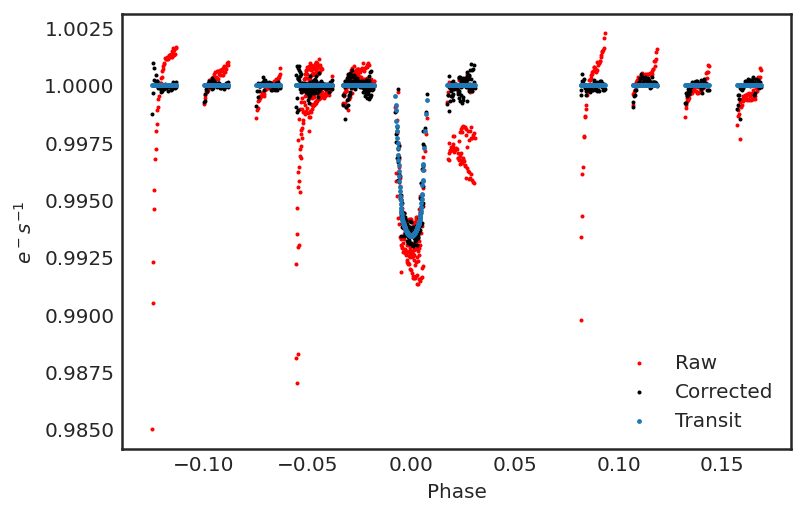

In [10]:
obs.plot()

In [34]:
obs.fit_model()

Fitting Transit/Eclipse Model: 100%|██████████████| 5/5 [01:21<00:00, 16.21s/it]


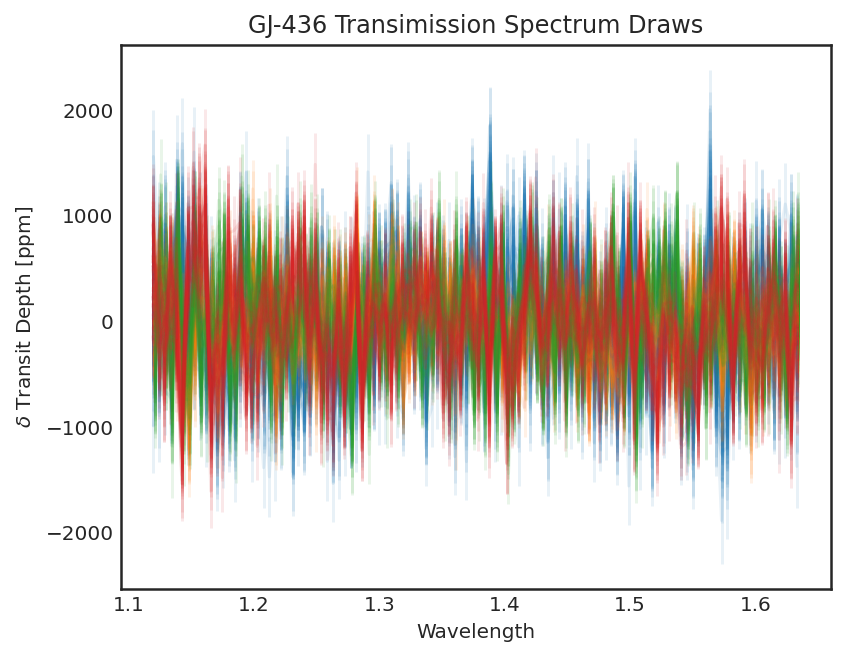

In [35]:
obs.plot_spectra()

<AxesSubplot:title={'center':'GJ-436 Transmission Spectrum, Visit: 1'}, xlabel='Wavelength', ylabel='$\\delta$ Transit Depth [ppm]'>

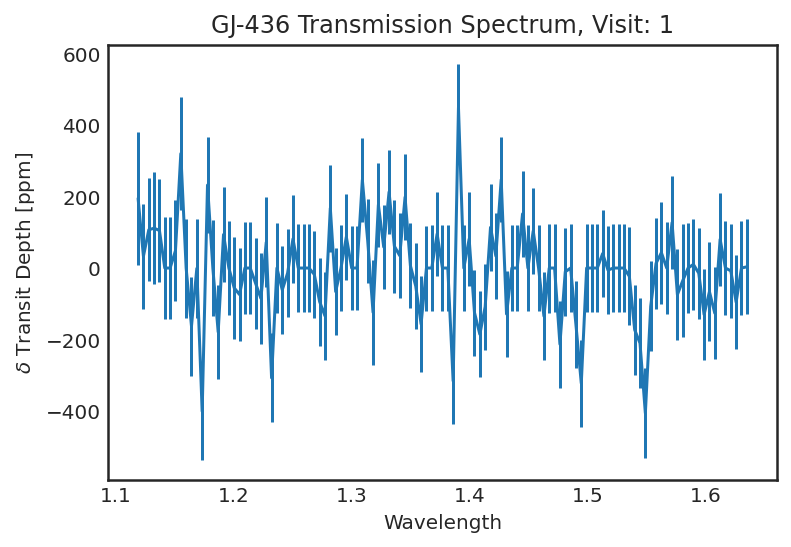

In [36]:
om.Spectra([visit.transmission_spectrum for visit in obs]).flatten().bin(bins=np.linspace(0.8, 1.7, 200)).plot()

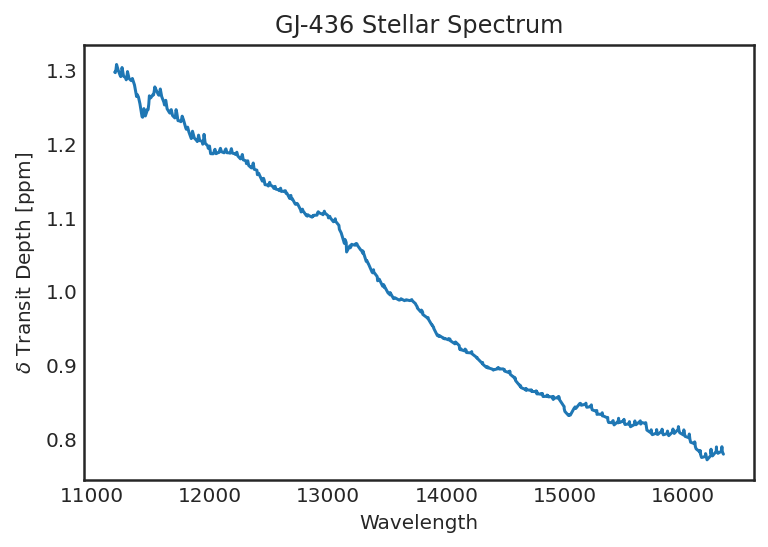

In [37]:
spec = obs.stellar_spectra
spec.plot()
spec.hdulist.writeto(f'results/{name}_stellar_spectrum.fits', overwrite=True)

In [38]:
from astropy.io import fits
try:
    hdulist = om.Spectra([visit.transmission_spectrum for visit in obs if visit.transmission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_transmission.fits')
except:
    pass
try:    
    hdulist = om.Spectra([visit.emission_spectrum for visit in obs if visit.emission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_emission.fits')
except:
    pass

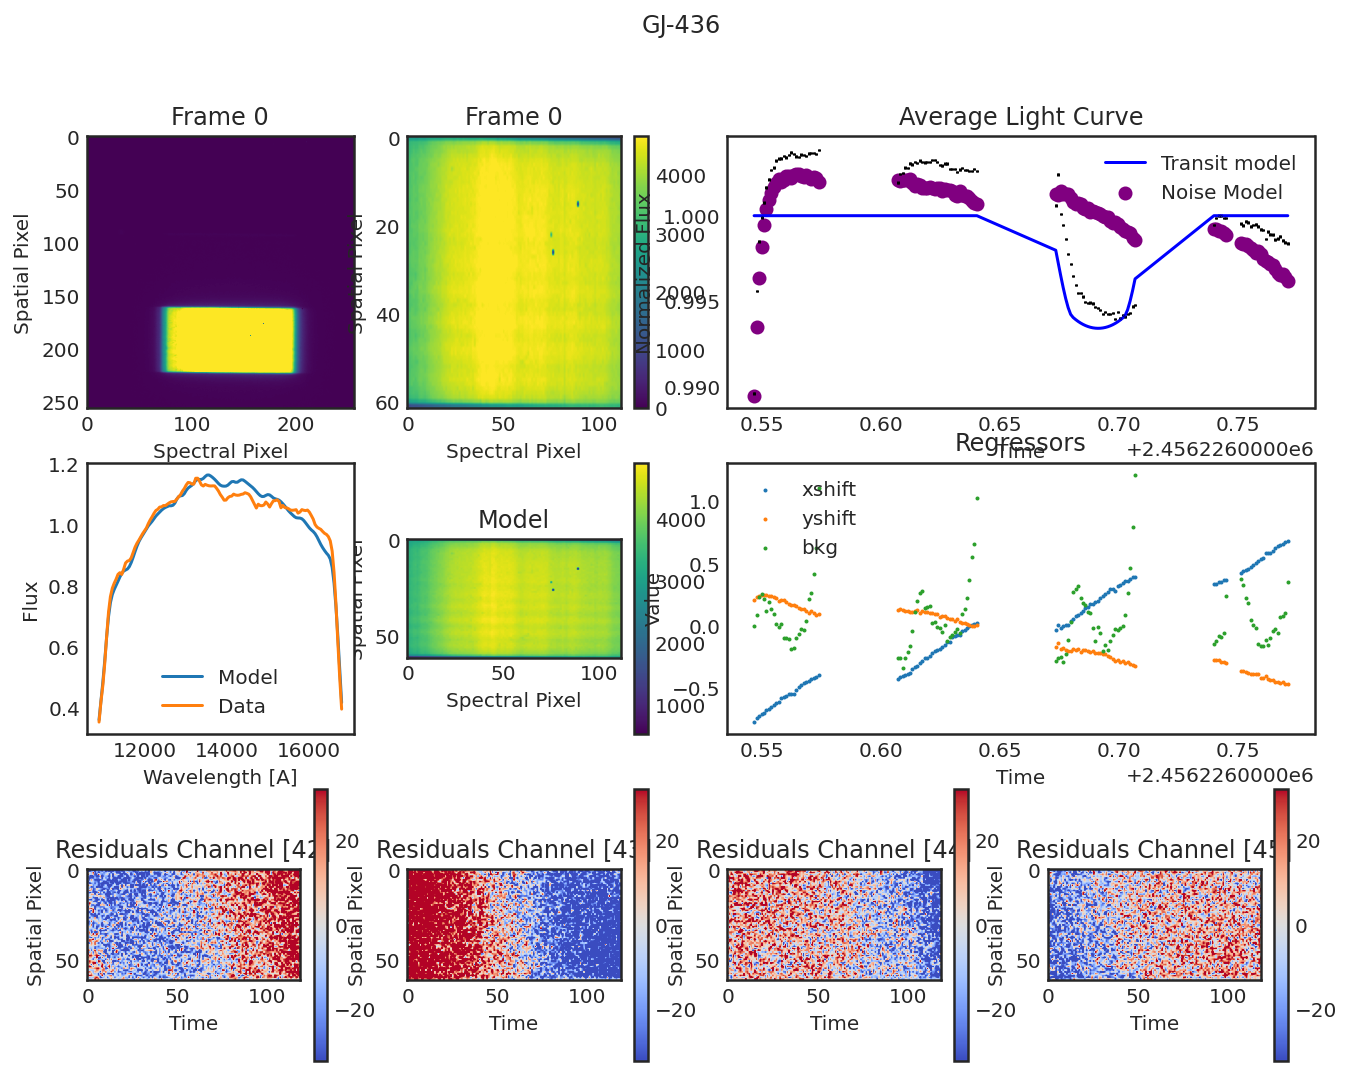

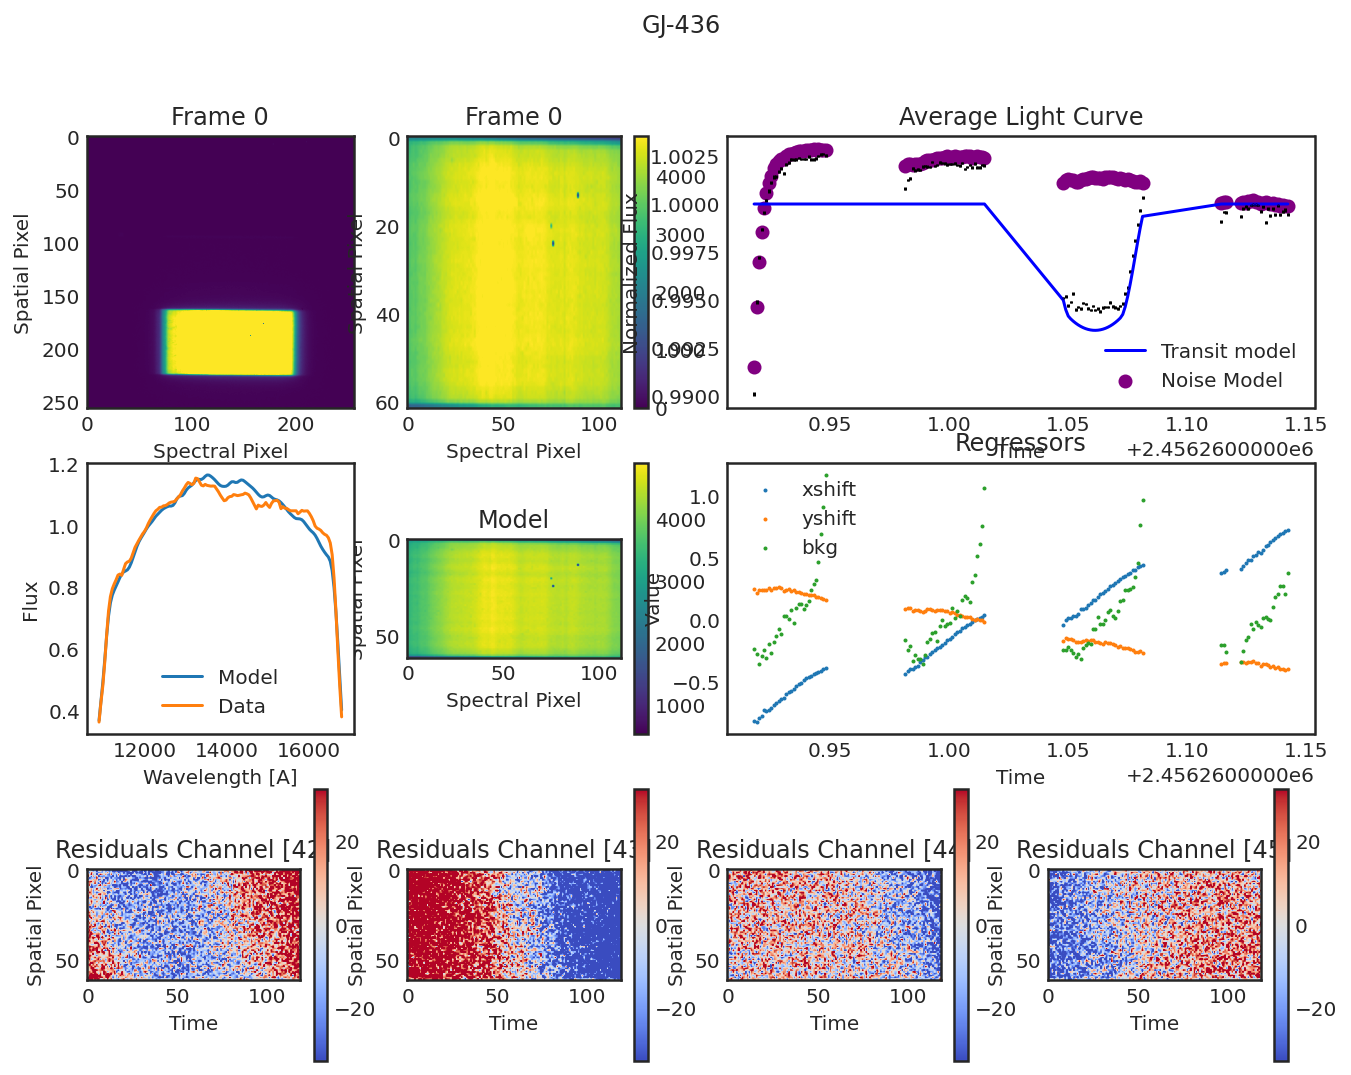

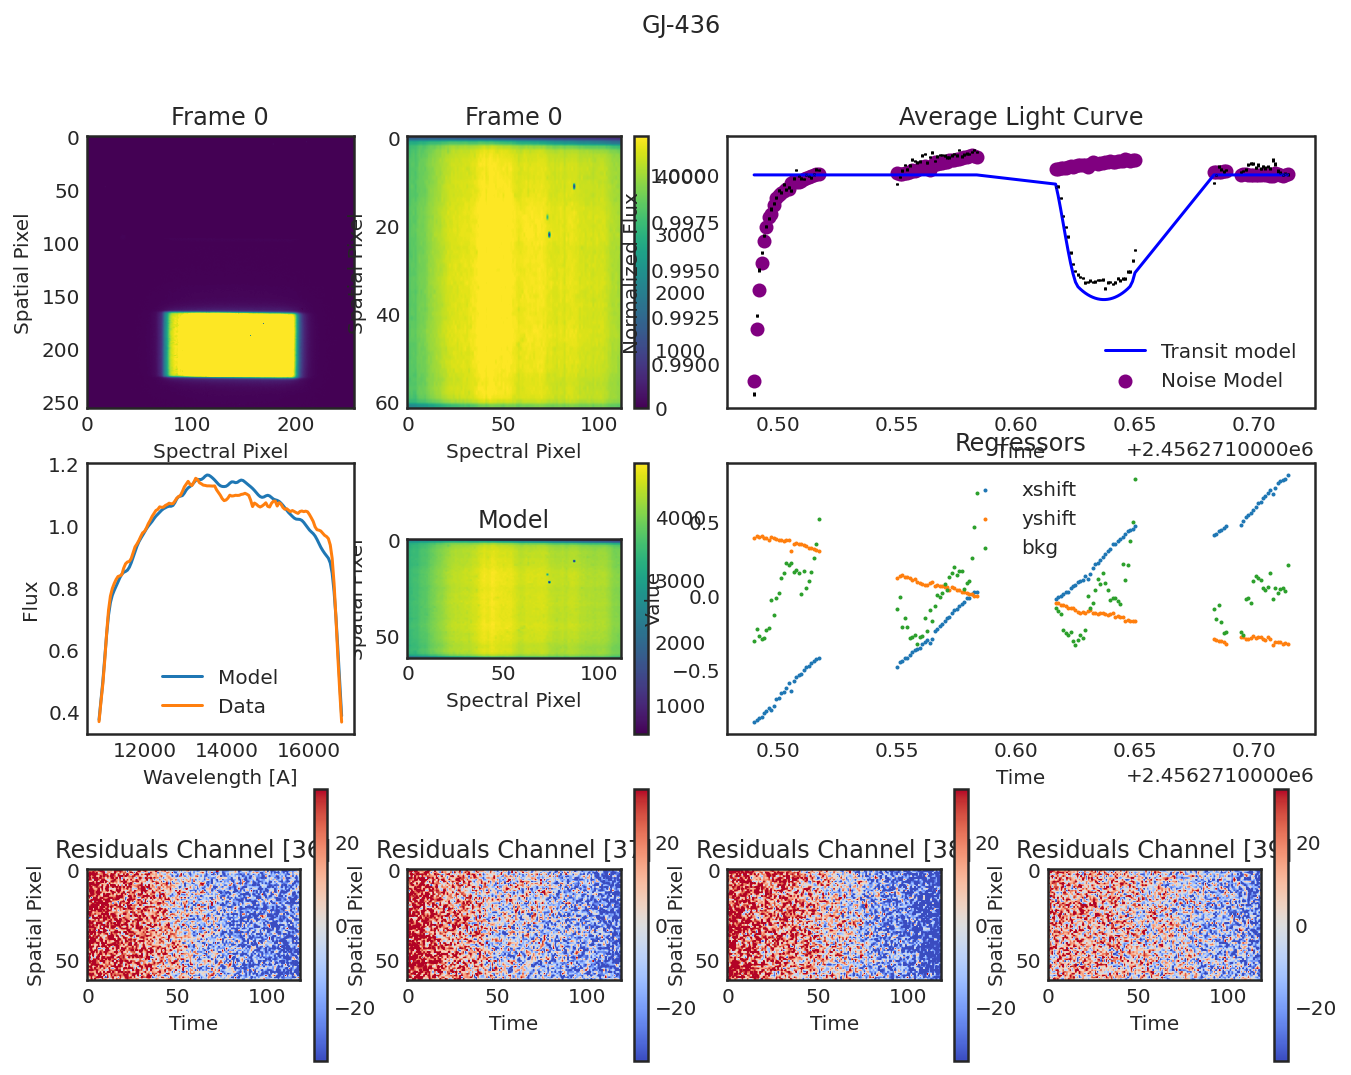

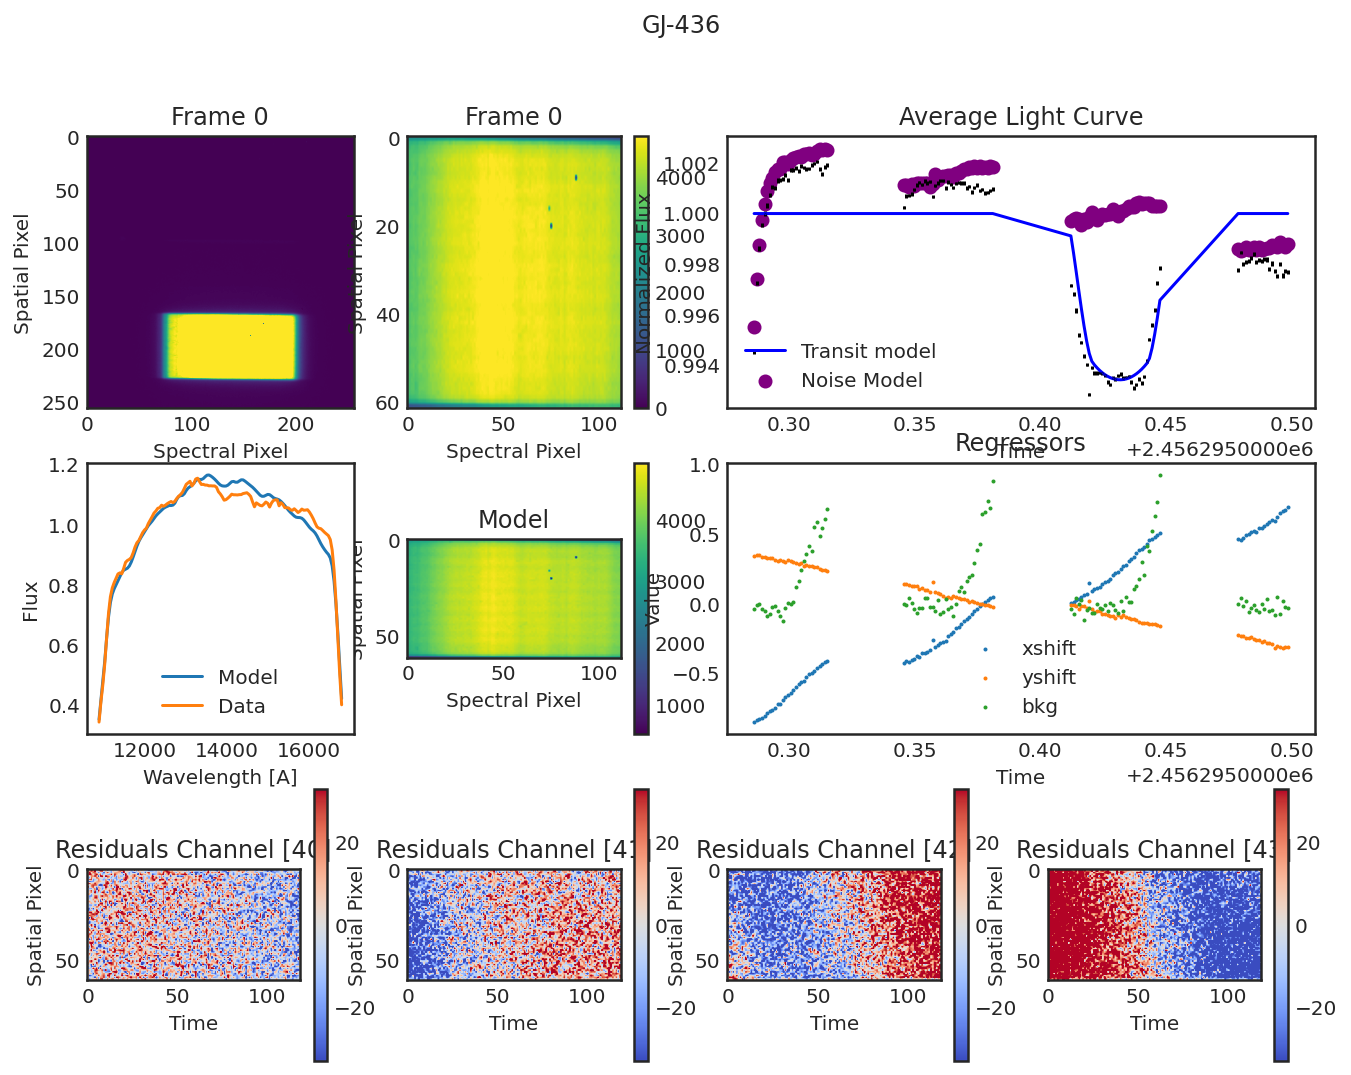

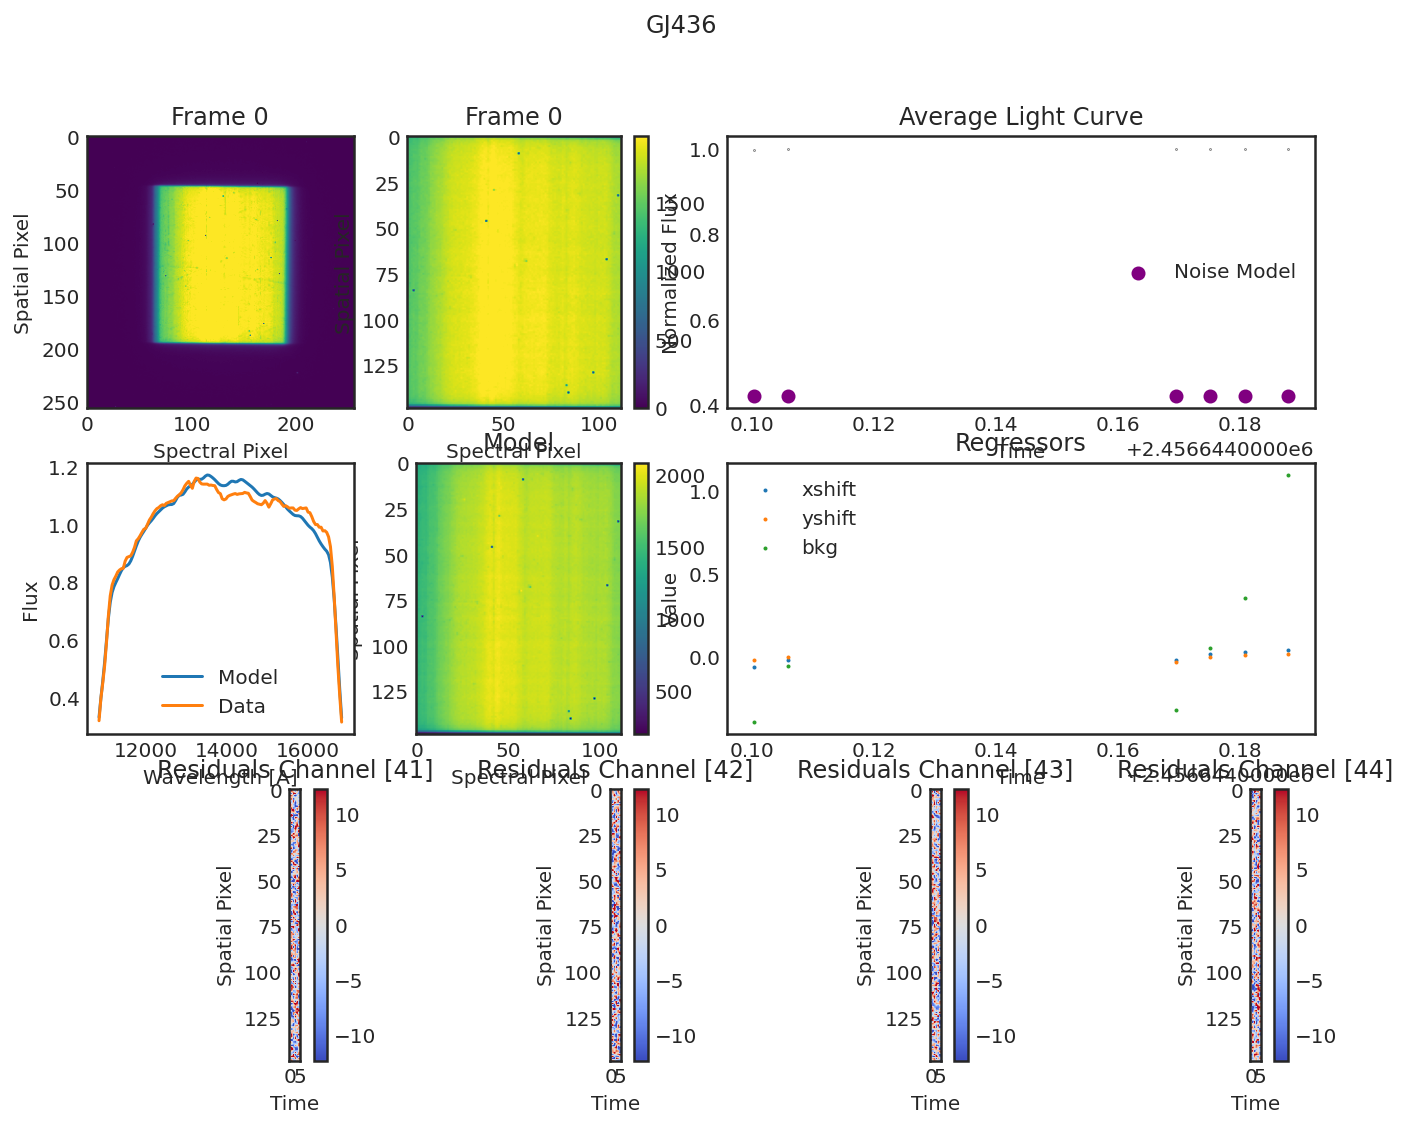

In [39]:
for visit in obs:
    visit.diagnose();
    plt.show();